In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import geopy.distance
import matplotlib.pyplot as plt
from shapely.geometry import Point

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit


from scipy import stats
from sklearn import metrics
import folium

import math

### Helper Functions

In [25]:
# loading taxi regions
taxi_regions = gpd.read_file('zip://../data/taxi_zones/taxi_zones.zip')

# translating polygon to lat/lng
crs = {'init': 'epsg:4326'}
taxi_regions = taxi_regions.to_crs(crs)
    

def pointWithinCircle(point, circle):
    ## Return if a given point is within a circle
    c = (circle[0], circle[1])
    r = circle[2]
    dist = geopy.distance.distance(c, point).meters
    if dist <= r:
        return True

    return False

def getSensorLocation(lat, lng):
    ## TODO: Refactor function return
    ## get neighboorhood ID of a coordinate
    point = Point(lng, lat)
    taxi_regions['intersect'] = taxi_regions.apply(lambda row: row['geometry'].intersects(point), axis=1)
    region =  taxi_regions[taxi_regions['intersect'] == True]['LocationID']
    return region.values[0]

def runEstimator(X, y, estimator, randomize):
    
    if(randomize == 'random'):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        estimator.fit(X_train, y_train)
        y_pred=estimator.predict(X_test)
    elif(randomize == 'continuous'):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
        estimator.fit(X_train, y_train)
        y_pred=estimator.predict(X_test)
        feature_importances = pd.DataFrame(estimator.feature_importances_, index = X_train.columns, columns=['importance'])
        print(feature_importances)
    elif(randomize == 'chunk'):
        X_train, X_test, y_train, y_test =  chunkSplitter(X, y, 0.4, 5)
#         estimator.fit(X_train, y_train)
#         y_pred=estimator.predict(X_test)
        print(X_train)
        
    return y_pred, y_test

def plotError(y_pred, y_test):

    print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))
    print('Bin Distance: ', metrics.mean_absolute_error(y_test, y_pred))
    
#     diffs = []
#     for i in range(0, len(y_pred)):
#         diffs.append(abs(y_test[i] - y_pred[i]))
     
#     print('Error Description:', pd.Series(diffs).describe())
#     pd.DataFrame(diffs).boxplot()
    

def plotClassifier(y_pred, y_test, title):
    df_test = pd.DataFrame(y_test)
    df_test['pred'] = y_pred

#     df_test.sort_values(by=['datetime'], inplace=True)
    df_test.sort_index(inplace=True)

    plt.figure(figsize=(15,5))
    plt.plot(df_test['bin'], label='test')
    plt.plot(df_test['pred'], label='pred')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#     plt.title(title)
    plt.show()
    
def chunkSplitter(X, y, test_size, n_chunks):
    
    X_test_local = pd.DataFrame()
    X_train_local = pd.DataFrame()
    y_test_local = pd.DataFrame()
    y_train_local = pd.DataFrame()
    
    X_length = X.shape[0]
    y_length = y.shape[0]
    
    X_test_length = math.floor(X_length * test_size)
    X_train_length = math.floor(X_length * (1 - test_size))
    
#     print('X_Test_Length', X_test_length)
#     print('X_Train_Length', X_train_length)
#     print('X_length: ', X_length)
    y_train_length = math.floor(y_length * test_size)
    y_test_length = math.floor(y_length * (1 - test_size))
    
    test_chunk_size = math.floor(X_test_length / n_chunks)
    train_chunk_size = math.floor(X_train_length / n_chunks)
    
#     print('test_chunk_size', test_chunk_size)
#     print('train_chunk_size', train_chunk_size)
#     print('n_chunks: ', n_chunks)
    
    flag = True
    range_initial = 0
    range_end = test_chunk_size
    while(flag):
        
#         print('range_initial: ', range_initial)
#         print('range_end: ', range_end)
        
#         print('(range_end+1): ', (range_end+1))
#         print('(range_end+train_chunk_size): ', (range_end+train_chunk_size))
        
        
        X_test_local = X_test_local.append(X.iloc[range_initial:range_end]) 
        X_train_local = X_train_local.append(X.iloc[(range_end):(range_end+train_chunk_size)])
 
        y_test_local = y_test_local.append(y.iloc[range_initial:range_end])
        y_train_local = y_train_local.append(y.iloc[range_end:(range_end+train_chunk_size)])
        
        range_initial += (test_chunk_size + train_chunk_size)
        range_end += (train_chunk_size + test_chunk_size)
        
        
        
        if(range_end > X_length):
            flag = False
            
    
    
        
        
    return X_train_local, X_test_local, y_train_local, y_test_local

### Loading Sensor Data

In [3]:
# Load sensors
selectedsensors = [ "sonycnode-b827eb0fedda.sonyc",
                    "sonycnode-b827eb42bd4a.sonyc",
#                     "sonycnode-b827eb44506f.sonyc",
#                     "sonycnode-b827eb73e772.sonyc",
#                     "sonycnode-b827eb74a519.sonyc",
#                     "sonycnode-b827eb84deb5.sonyc",
                    "sonycnode-b827ebb40450.sonyc"]

# Sensor data
datapath = '../data/sensor_data/'
filename = datapath + '/nodes.txt'

f = open(filename)
sensors = {}

for line in f:
    s, lat, lon = line.split(' ')
    if s in selectedsensors:
        sensors[s] = {}
        
        # Calculating the average over one hour of SPL data
        sensorData = pd.read_pickle(datapath +s+ '.pkl')
        sensorData['dbas'] = sensorData['sum'] / sensorData['count']
        
        sensors[s]['sensorData'] = sensorData
        sensors[s]['lat'] = float(lat)
        sensors[s]['lon'] = float(lon)
        sensors[s]['taxi_region'] = getSensorLocation(sensors[s]['lat'], sensors[s]['lon'])

### Plotting used sensors

In [4]:
map_osm = folium.Map(location=[40.742, -73.956], zoom_start=12, tiles="cartodbpositron")
for key in sensors.keys():
    folium.CircleMarker(location=[sensors[key]['lat'], sensors[key]['lon']], radius=5,  fill=True, fill_opacity=0.5, fill_color="red", color="black").add_to(map_osm)

map_osm

### Loading 311 Data

In [5]:
df_311 = pd.read_pickle('../rawdata/311_noise.pkl')
df_311['datetime'] = pd.to_datetime(df_311['Created Date'])
df_311 = df_311.set_index(['datetime'])
df_311.sort_index(inplace=True)
df_311['count'] = 1
df_311['hour'] = df_311.index.hour
df_311['weekday'] = df_311.index.weekday

In [6]:
df_311.head(5)

,Created Date,Closed Date,Descriptor,Latitude,Longitude,count,hour,weekday
datetime,,,,,,,,
2010-01-01 00:03:46,01/01/2010 12:03:46 AM,01/01/2010 01:13:06 AM,Loud Television,40.612155,-73.955036,1,0,4
2010-01-01 00:08:02,01/01/2010 12:08:02 AM,01/01/2010 03:53:37 AM,Loud Music/Party,40.635708,-74.006853,1,0,4
2010-01-01 00:08:29,01/01/2010 12:08:29 AM,01/01/2010 12:27:41 AM,Loud Music/Party,40.759486,-73.989135,1,0,4
2010-01-01 00:08:30,01/01/2010 12:08:30 AM,01/01/2010 12:41:04 AM,Loud Television,40.634762,-74.169727,1,0,4
2010-01-01 00:15:08,01/01/2010 12:15:08 AM,01/01/2010 01:21:23 AM,Banging/Pounding,40.755060,-73.832251,1,0,4


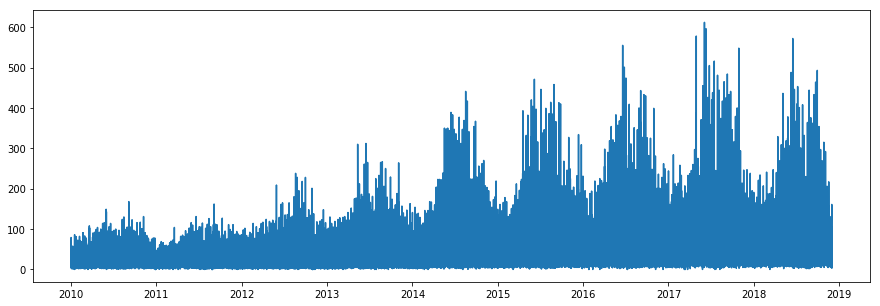

In [7]:
preview_311 = df_311[['count']].resample('H').agg({'count': 'sum'})

plt.figure(figsize=(15,5))
plt.plot(preview_311)
plt.show()

### Loading Taxi Data

In [8]:
df_taxi = pd.read_pickle('../rawdata/taxi_2018.pkl')
df_taxi['datetime'] = pd.to_datetime(df_taxi['datetime'])
df_taxi.sort_values(by=['datetime'], inplace=True)
df_taxi.set_index(['datetime'], inplace = True)
df_taxi['count'] = 1
df_taxi['hour'] = df_taxi.index.hour
df_taxi['weekday'] = df_taxi.index.weekday

In [9]:
df_taxi.head(5)

,location,count,hour,weekday
datetime,,,,
1998-01-17 20:47:45,95,1,20,5
2001-01-01 00:01:48,43,1,0,0
2001-01-01 00:02:26,48,1,0,0
2001-01-01 00:04:49,48,1,0,0
2001-01-01 00:05:12,140,1,0,0


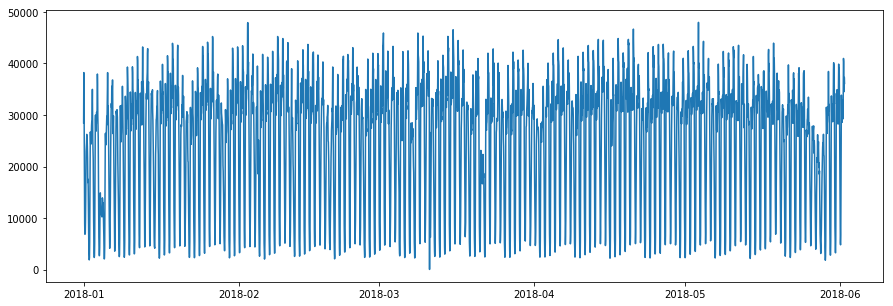

In [10]:
preview_taxi = df_taxi[['count']].resample('H').agg({'count': 'sum'})
preview_taxi = preview_taxi['2018-01-01':'2018-06-01']


plt.figure(figsize=(15,5))
plt.plot(preview_taxi)
plt.show()

### Loading weather (speed wind) data

In [11]:
cols = [0,11]
header_weather = pd.read_csv('../rawdata/weather.header', usecols = cols)
df_weather = pd.read_csv('../rawdata/weather', usecols = cols, names=header_weather.columns.values)
df_weather = df_weather.sort_values(by='time', ascending=False)
df_weather['datetime'] = pd.to_datetime(df_weather['time'],unit='s')
df_weather['datetime'].dt.tz_localize('utc').dt.tz_convert('US/Central')
df_weather.sort_values(by=['datetime'], inplace=True)
df_weather.set_index(['datetime'], inplace = True)
df_wind = df_weather.resample('H').agg({'Spd[Wind]': 'min'})
df_wind['hour'] = df_wind.index.hour
df_wind['weekday'] = df_wind.index.weekday

In [12]:
df_wind.head(5)

,Spd[Wind],hour,weekday
datetime,,,
2010-01-01 01:00:00,0.0,1,4
2010-01-01 02:00:00,0.0,2,4
2010-01-01 03:00:00,0.0,3,4
2010-01-01 04:00:00,0.0,4,4
2010-01-01 05:00:00,0.0,5,4


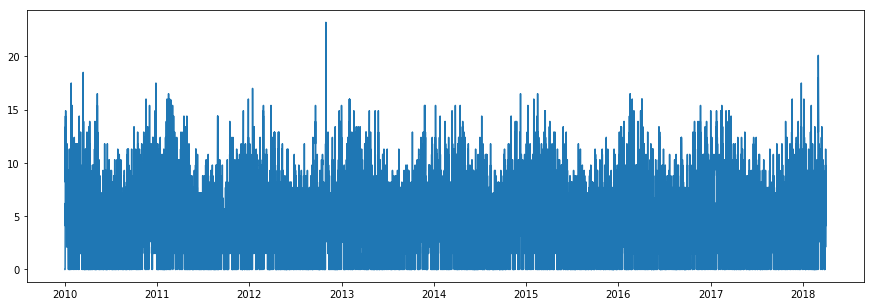

In [13]:
plt.figure(figsize=(15,5))
plt.plot(df_wind['Spd[Wind]'])
plt.show()

### Pairing Timeseries

In [15]:
radius = 200 # radius in meters
for s in sensors:    
    
    ## Choosing the largest intersection between datasets
#     st311, en311 = df_311.index[0], df_311.index[-1]
#     stsensor, ensensor = sensors[s]['sensorData'].index[0], sensors[s]['sensorData'].index[-1]
#     stTaxi, enTaxi = df_taxi.index[0], df_taxi.index[-1]
#     stWeather, enWeather = df_weather.index[0], df_weather.index[-1]
#     st, en = max(stsensor, st311, stTaxi, stWeather), min(ensensor, en311, enTaxi, enWeather)
#     st, en = max(stsensor, st311, stTaxi), min(ensensor, en311, enTaxi)

    st = '2018-01-01'
    en = '2018-04-01'
    
    ## Filtering datasets
    filtered_311 = df_311[st : en]
    filtered_taxi = df_taxi[st : en]
    filtered_wind = df_wind[st: en]
    filtered_sensor = sensors[s]['sensorData'][st : en]
    
    ## Adding datasets to the initial Data Structure
lat    sensors[s]['311'] = sensors[s]['311'].resample('H').agg({'count': 'sum'})
#     sensors[s]['311'] = (sensors[s]['311'] + empty).fillna(0)
    
    sensors[s]['taxi'] = filtered_taxi[filtered_taxi['location'] == sensors[s]['taxi_region']]
    sensors[s]['taxi'] = sensors[s]['taxi'].resample('H').agg({'count': 'sum'})
#     sensors[s]['taxi'] = (sensors[s]['taxi'] + empty).fillna(0)

    sensors[s]['wind'] = filtered_wind.resample('H').agg({'Spd[Wind]': 'mean'})
    
    sensors[s]['sensor_data'] = filtered_sensor

## Plotting features

### SPL

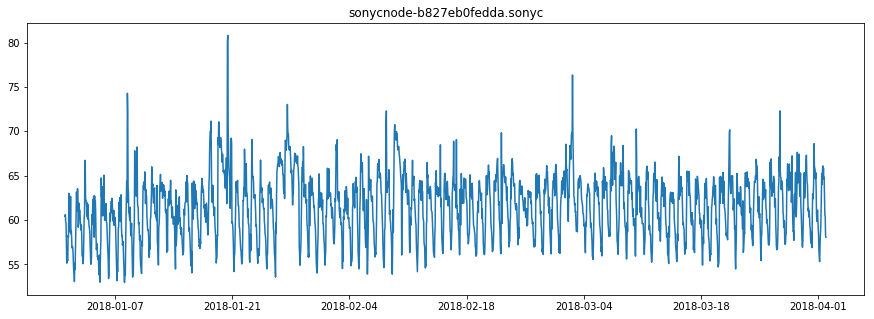

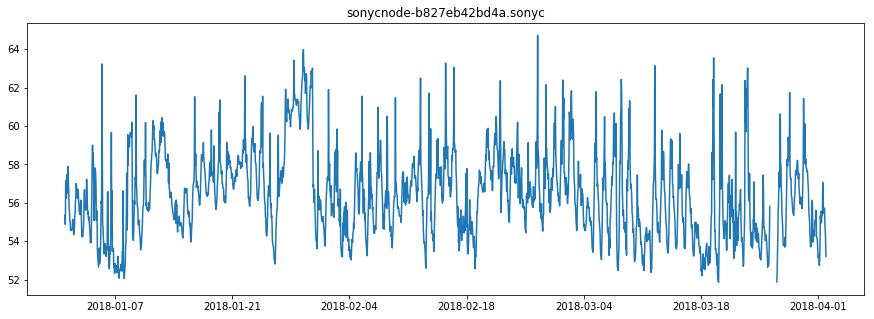

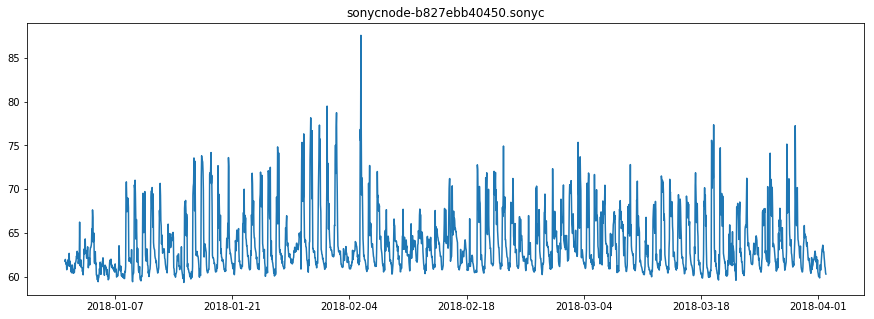

In [16]:
for key in sensors.keys():
    plt.figure(figsize=(15,5))
    plt.plot(sensors[key]['sensor_data']['dbas'])
    plt.title(key)
    plt.show()

### 311

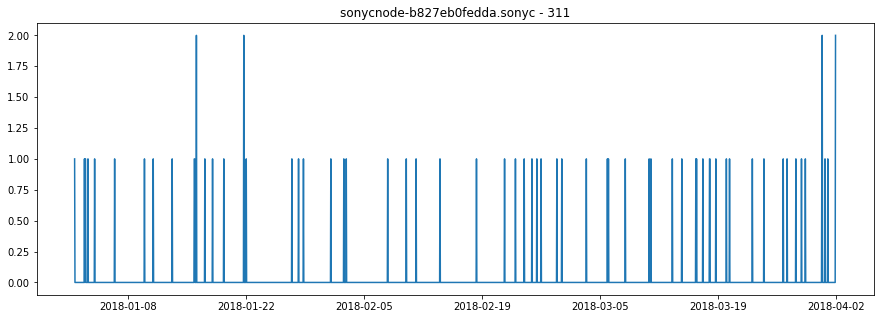

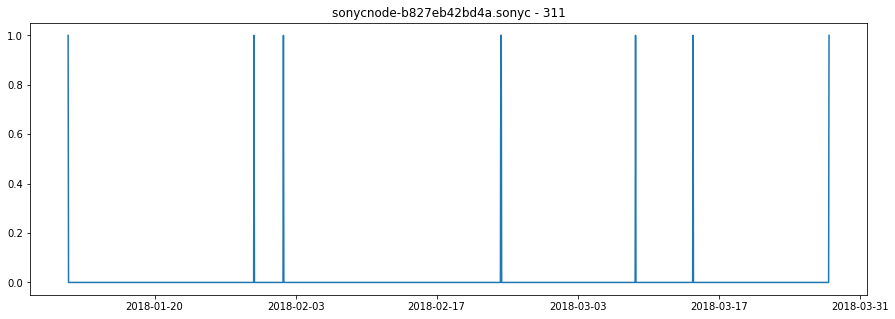

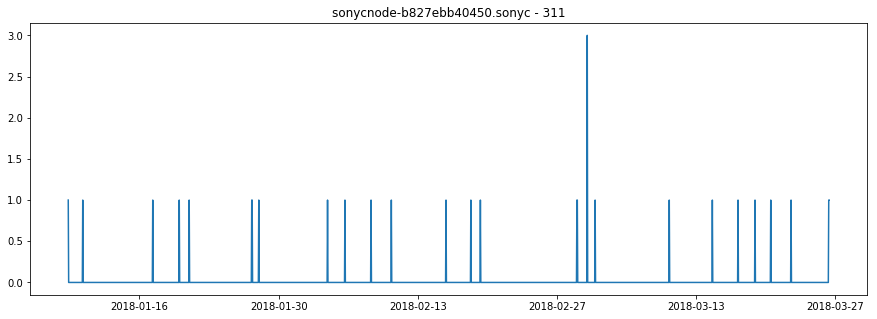

In [41]:
for key in sensors.keys():
    plt.figure(figsize=(15,5))
    plt.plot(sensors[key]['311'])
    plt.title(key+' - 311')
    plt.show()

### Taxi

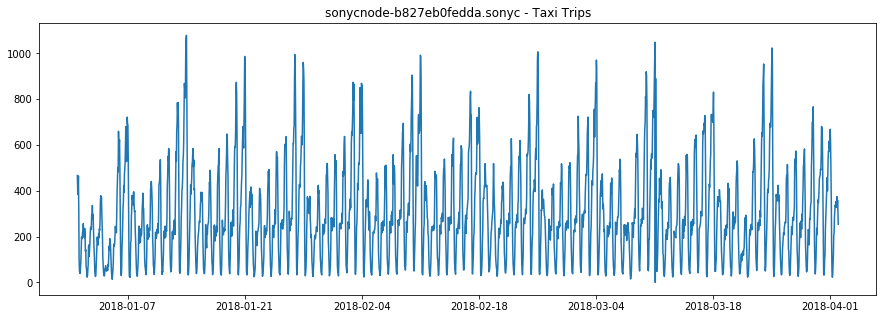

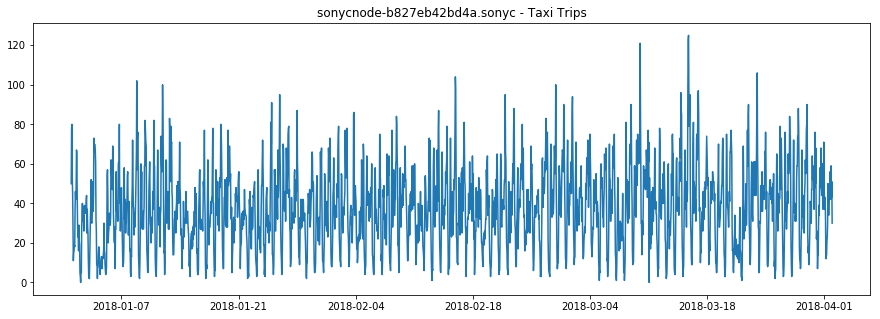

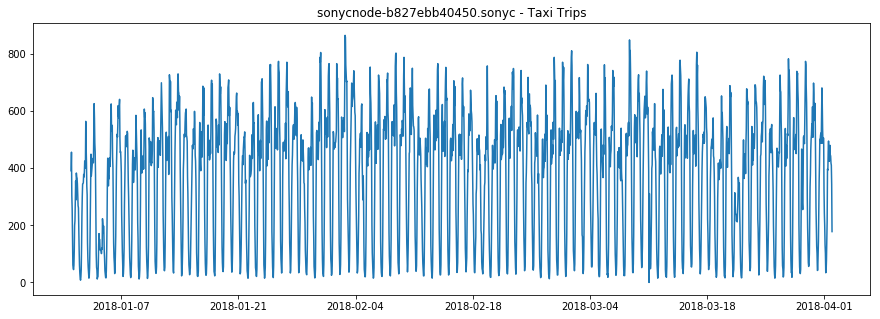

In [42]:
for key in sensors.keys():
    plt.figure(figsize=(15,5))
    plt.plot(sensors[key]['taxi'])
    plt.title(key+' - Taxi Trips')
    plt.show()

### Wind Speed

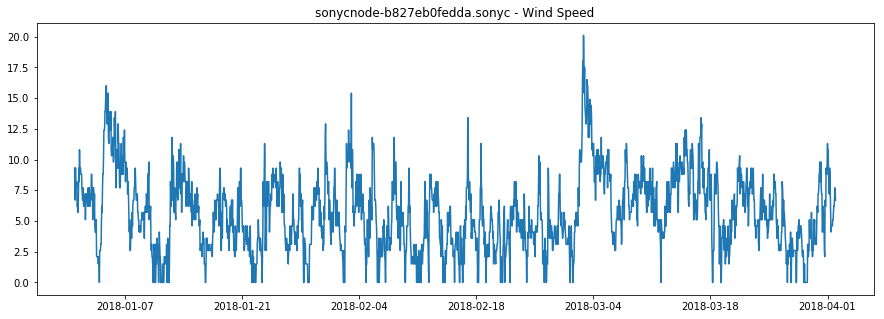

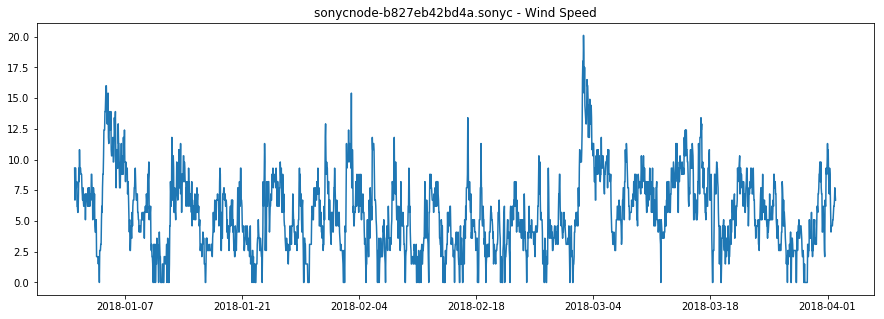

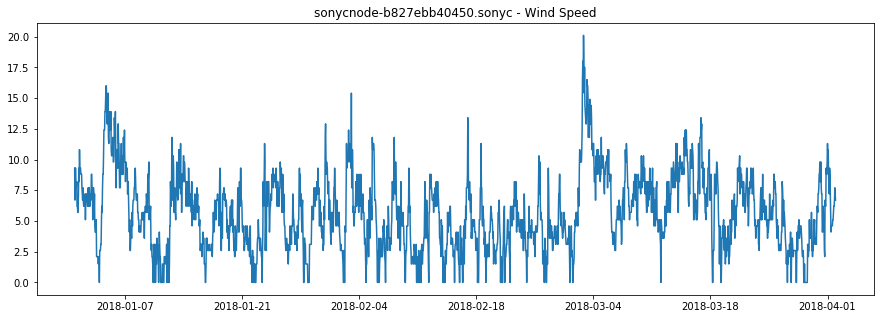

In [43]:
for key in sensors.keys():
    plt.figure(figsize=(15,5))
    plt.plot(sensors[key]['wind'])
    plt.title(key+' - Wind Speed')
    plt.show()

## Random Forest Classifier

In [17]:
rfc = RandomForestClassifier(n_estimators=1000, random_state=42)

In [18]:
sensors_df = []

features = ['taxi', '311', 'wind', 'dbas']
for sensor in sensors: 
    
    ## Create empty dataframe so that we are sure all variables have same number of entries
    df_base = pd.DataFrame()
    df_base['datetime'] = pd.date_range(st, en, freq="1h")
#     df_base['count'] = 0
    df_base.set_index(['datetime'], inplace = True)
    
    for feature in features:
        if(feature == 'dbas'):
            df_base[feature] = sensors[sensor]['sensor_data'][feature]
        else: 
            df_base[feature] = sensors[sensor][feature]
            
            
    ### Filling non-numeric entries with 0
    df_base.fillna(0, inplace=True)
    
    
    ## Setting bin size
    bin_size = 1
    df_base['bin'] = (df_base['dbas'] / bin_size).astype(int)
    

    ### Calculating sin and cos (daily interactions semantic)

    # df_base.drop(['count'], inplace=True, axis=1)
    df_base['hour'] = df_base.index.hour
    df_base['weekday'] = df_base.index.weekday
    df_base['hour_sin'] = np.sin(df_base['hour'])
    df_base['hour_cos'] = np.cos(df_base['hour'])
    df_base['weekday_sin'] = np.sin(df_base['weekday'])
    df_base['weekday_cos'] = np.cos(df_base['weekday'])
        

        
    sensors_df.append(df_base)

# 311 (Non-Random Split)

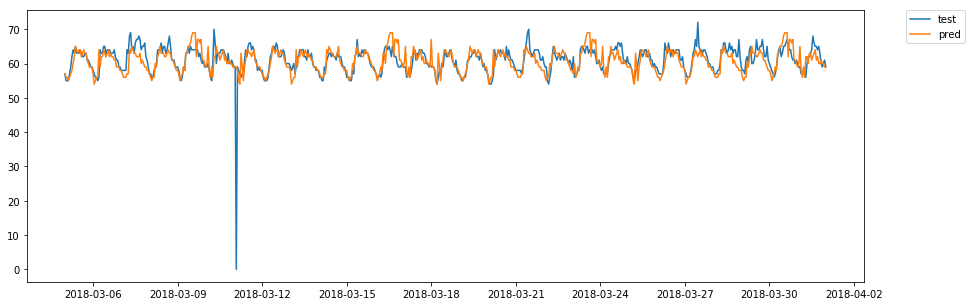

Accuracy:  0.22342064714946072
Bin Distance:  1.8243451463790448
Error Description: count    649.000000
mean       1.824345
std        2.817487
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       59.000000
dtype: float64


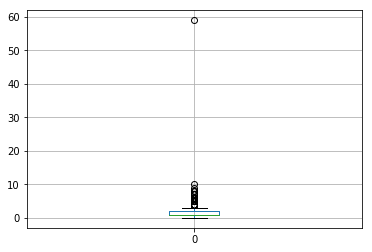

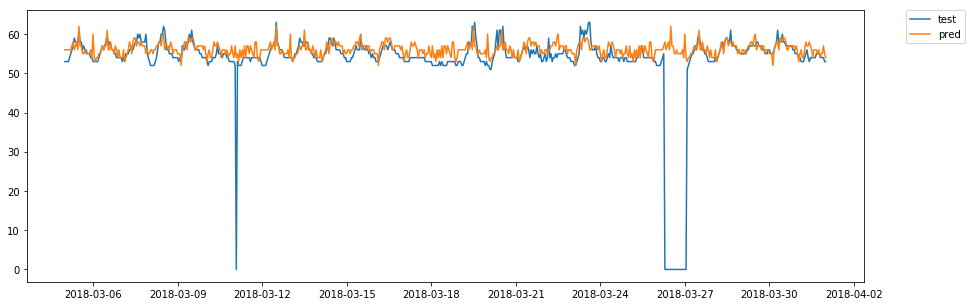

Accuracy:  0.19106317411402157
Bin Distance:  3.3343605546995376
Error Description: count    649.000000
mean       3.334361
std        9.540884
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       62.000000
dtype: float64


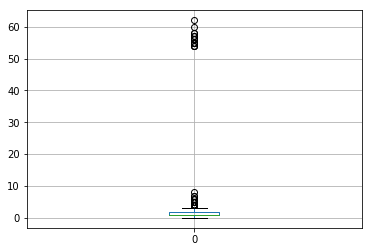

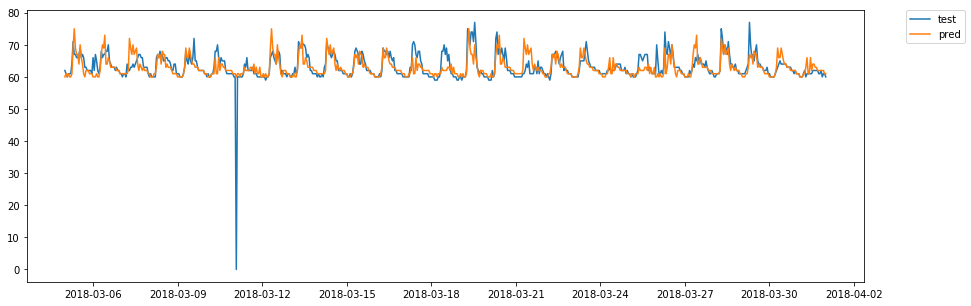

Accuracy:  0.29583975346687214
Bin Distance:  1.6702619414483821
Error Description: count    649.000000
mean       1.670262
std        2.980760
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max       60.000000
dtype: float64


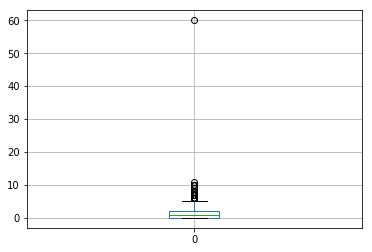

In [49]:
for sensor in sensors_df:
    X = sensor[['311', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos']]
    y = sensor['bin']
    y_pred, y_test = runEstimator(X, y, rfc, False)
    plotClassifier(y_pred, y_test, sensor)
    plotError(y_pred, y_test)

# 311 (Random Split)

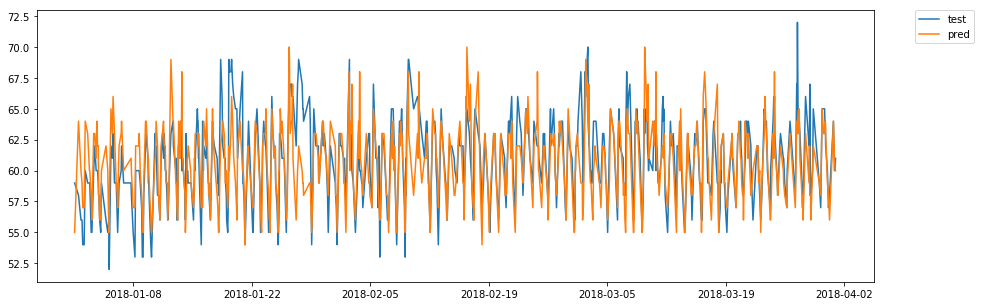

Accuracy:  0.19568567026194145
Bin Distance:  1.8305084745762712
Error Description: count    649.000000
mean       1.830508
std        1.781834
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        9.000000
dtype: float64


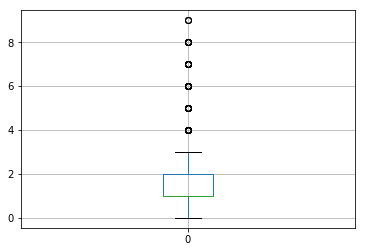

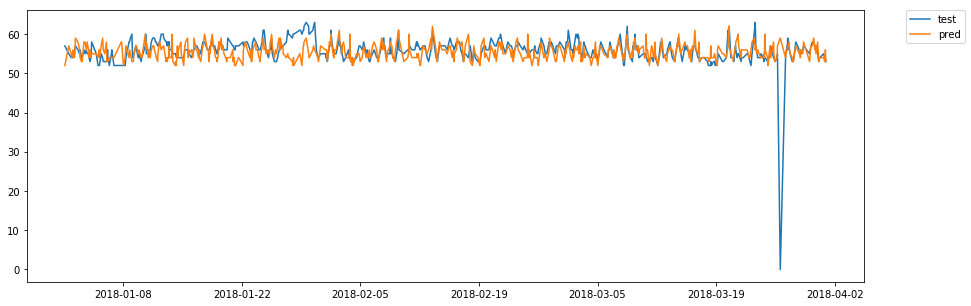

Accuracy:  0.18181818181818182
Bin Distance:  1.8690292758089369
Error Description: count    649.000000
mean       1.869029
std        2.707405
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max       59.000000
dtype: float64


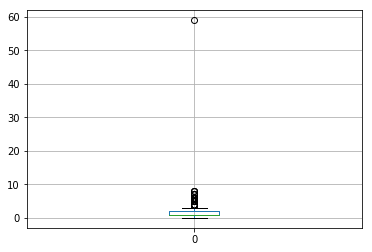

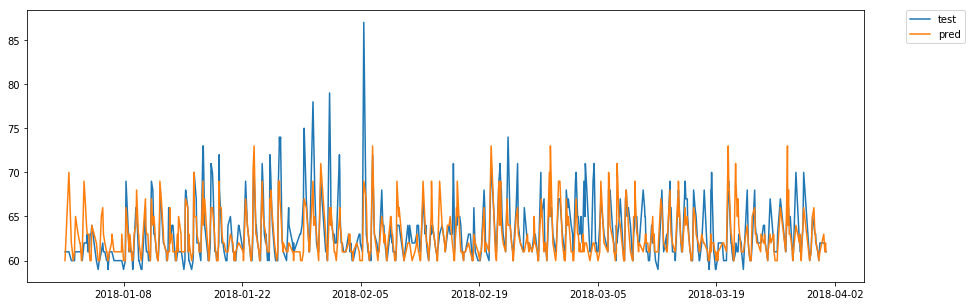

Accuracy:  0.2942989214175655
Bin Distance:  1.6070878274268106
Error Description: count    649.000000
mean       1.607088
std        2.037764
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max       18.000000
dtype: float64


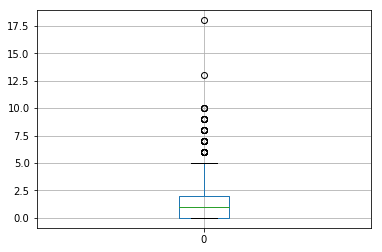

In [188]:
for sensor in sensors_df:
    X = sensor[['311', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos']]
    y = sensor['bin']
    y_pred, y_test = runEstimator(X, y, rfc, True)
    plotClassifier(y_pred, y_test, sensor)
    plotError(y_pred, y_test)

# 311 (Chunk Split)

In [143]:
for sensor in sensors_df:
    X = df_base[['311',  'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos']]
    y = df_base['bin']
    y_pred, y_test = runEstimator(X, y, rfc, 'chunk')

                     311  hour_sin  hour_cos  weekday_sin  weekday_cos
datetime                                                              
2018-01-08 04:00:00  0.0 -0.756802 -0.653644     0.000000     1.000000
2018-01-08 05:00:00  0.0 -0.958924  0.283662     0.000000     1.000000
2018-01-08 06:00:00  0.0 -0.279415  0.960170     0.000000     1.000000
2018-01-08 07:00:00  0.0  0.656987  0.753902     0.000000     1.000000
2018-01-08 08:00:00  0.0  0.989358 -0.145500     0.000000     1.000000
2018-01-08 09:00:00  0.0  0.412118 -0.911130     0.000000     1.000000
2018-01-08 10:00:00  0.0 -0.544021 -0.839072     0.000000     1.000000
2018-01-08 11:00:00  0.0 -0.999990  0.004426     0.000000     1.000000
2018-01-08 12:00:00  0.0 -0.536573  0.843854     0.000000     1.000000
2018-01-08 13:00:00  0.0  0.420167  0.907447     0.000000     1.000000
2018-01-08 14:00:00  0.0  0.990607  0.136737     0.000000     1.000000
2018-01-08 15:00:00  0.0  0.650288 -0.759688     0.000000     1.000000
2018-0

UnboundLocalError: local variable 'y_pred' referenced before assignment

# 311 + Taxi (Non-Random Split)

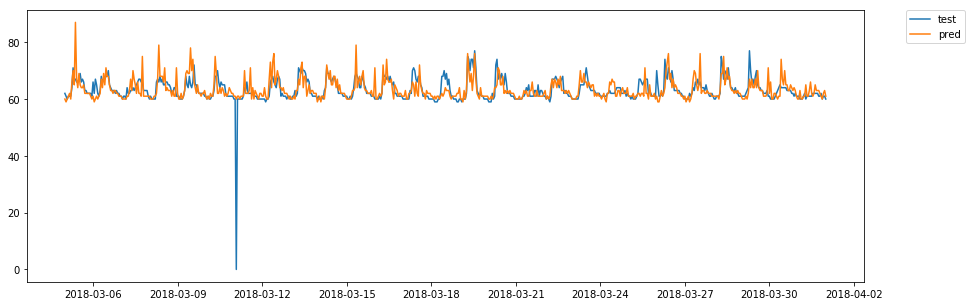

Accuracy:  0.23112480739599384
Bin Distance:  2.061633281972265
Error Description: count    649.000000
mean       2.061633
std        3.238830
min        0.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       60.000000
dtype: float64


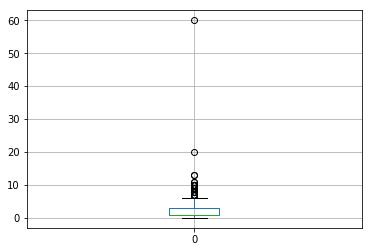

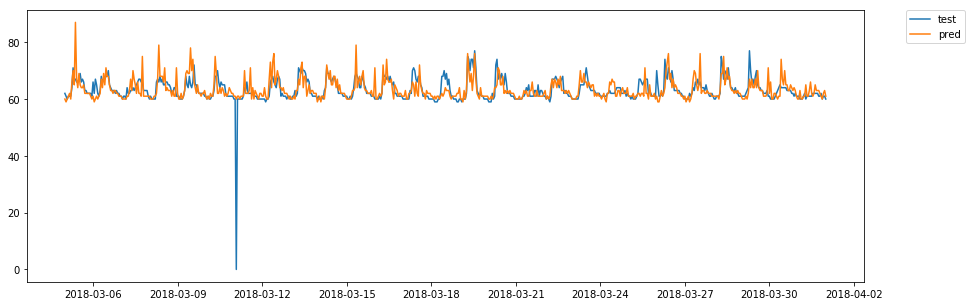

Accuracy:  0.23112480739599384
Bin Distance:  2.061633281972265
Error Description: count    649.000000
mean       2.061633
std        3.238830
min        0.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       60.000000
dtype: float64


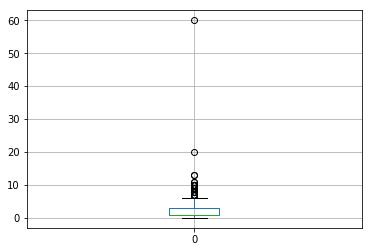

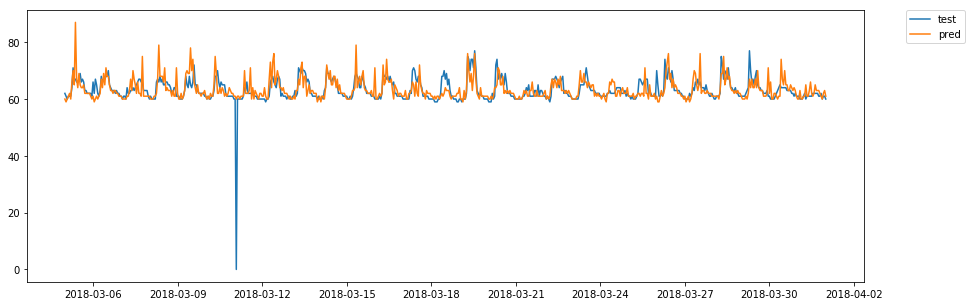

Accuracy:  0.23112480739599384
Bin Distance:  2.061633281972265
Error Description: count    649.000000
mean       2.061633
std        3.238830
min        0.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       60.000000
dtype: float64


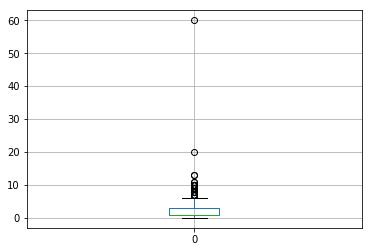

In [190]:
for sensor in sensors_df:
    X = df_base[['311', 'taxi',  'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos']]
    y = df_base['bin']
    y_pred, y_test = runEstimator(X, y, rfc, False)
    plotClassifier(y_pred, y_test, sensor)
    plotError(y_pred, y_test)

# 311 + Taxi (Random Split)

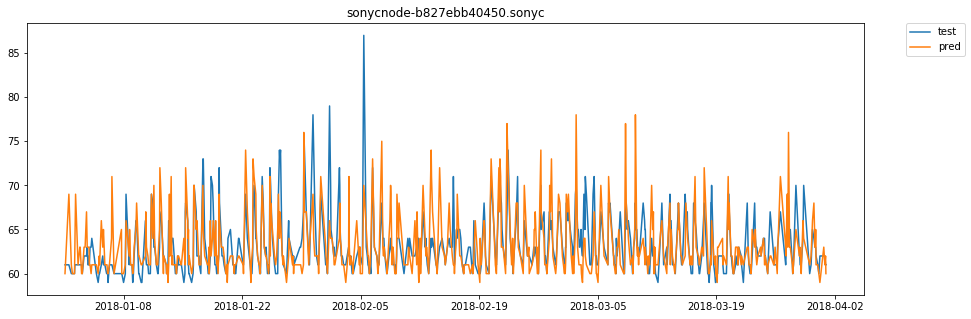

Accuracy:  0.23728813559322035
Bin Distance:  1.9291217257318953
Error Description: count    649.000000
mean       1.929122
std        2.245963
min        0.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       17.000000
dtype: float64


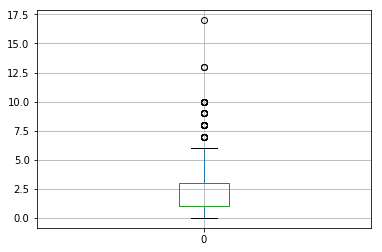

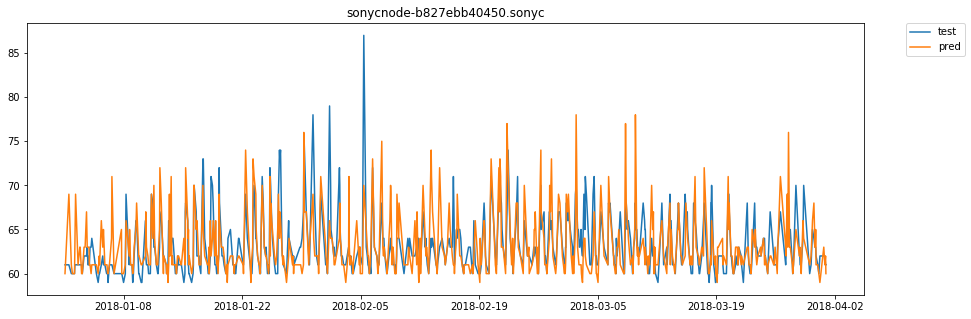

Accuracy:  0.23728813559322035
Bin Distance:  1.9291217257318953
Error Description: count    649.000000
mean       1.929122
std        2.245963
min        0.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       17.000000
dtype: float64


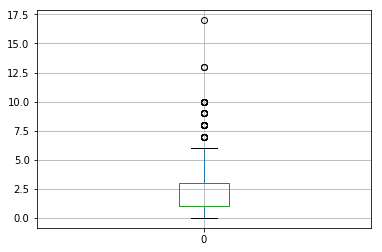

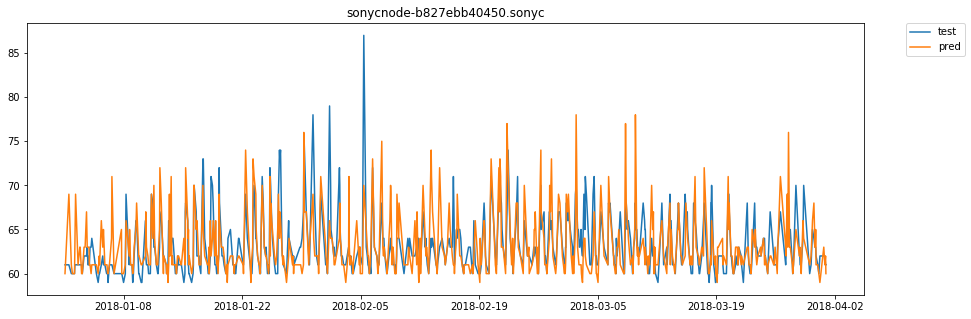

Accuracy:  0.23728813559322035
Bin Distance:  1.9291217257318953
Error Description: count    649.000000
mean       1.929122
std        2.245963
min        0.000000
25%        1.000000
50%        1.000000
75%        3.000000
max       17.000000
dtype: float64


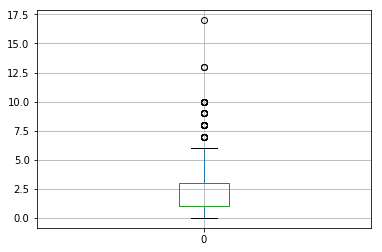

In [130]:
for sensor in sensors_df:
    X = df_base[['311', 'taxi',  'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos']]
    y = df_base['bin']
    y_pred, y_test = runEstimator(X, y, rfc, True)
    plotClassifier(y_pred, y_test, sensor)
    plotError(y_pred, y_test)

### 311 + Taxi + Wind Speed (Non-Random Split)

             importance
311            0.006218
taxi           0.378198
wind           0.243761
hour_sin       0.114577
hour_cos       0.117701
weekday_sin    0.069364
weekday_cos    0.070182


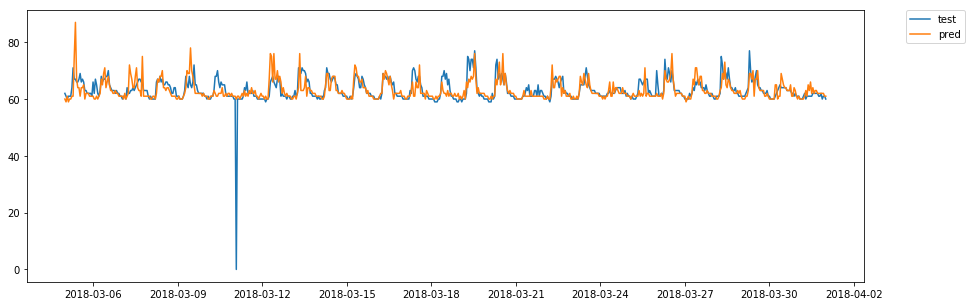

Accuracy:  0.2773497688751926
Bin Distance:  1.8782742681047766
Error Description: count    649.000000
mean       1.878274
std        3.190307
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max       60.000000
dtype: float64
             importance
311            0.006218
taxi           0.378198
wind           0.243761
hour_sin       0.114577
hour_cos       0.117701
weekday_sin    0.069364
weekday_cos    0.070182


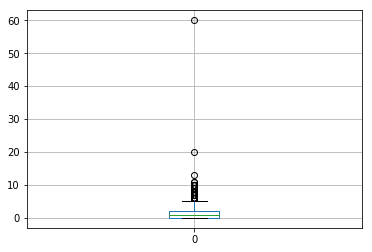

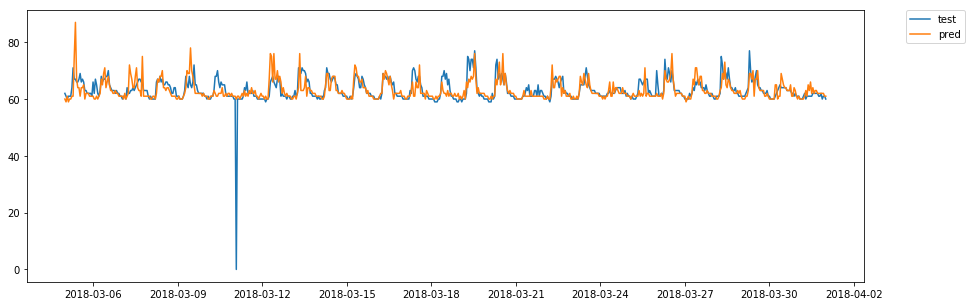

Accuracy:  0.2773497688751926
Bin Distance:  1.8782742681047766
Error Description: count    649.000000
mean       1.878274
std        3.190307
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max       60.000000
dtype: float64
             importance
311            0.006218
taxi           0.378198
wind           0.243761
hour_sin       0.114577
hour_cos       0.117701
weekday_sin    0.069364
weekday_cos    0.070182


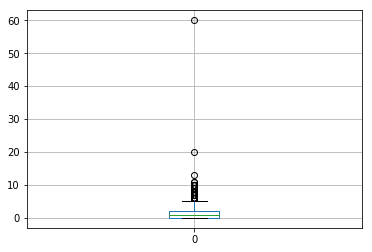

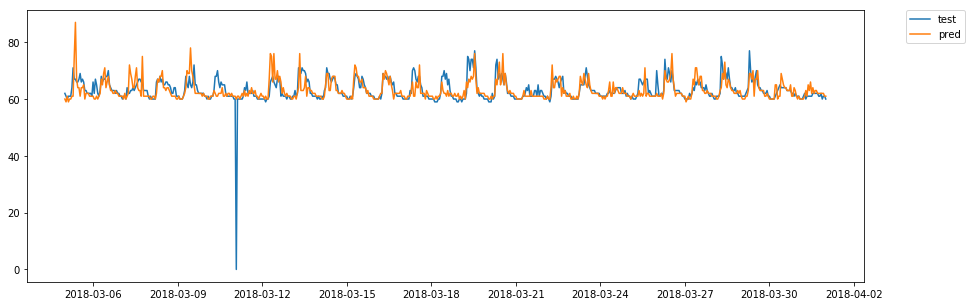

Accuracy:  0.2773497688751926
Bin Distance:  1.8782742681047766
Error Description: count    649.000000
mean       1.878274
std        3.190307
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max       60.000000
dtype: float64


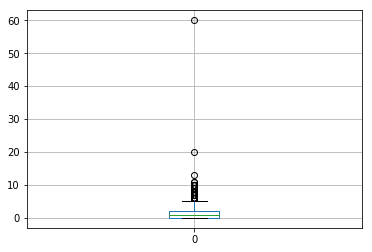

In [27]:
for sensor in sensors_df:
    X = df_base[['311', 'taxi', 'wind', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos']]
    y = df_base['bin']
    y_pred, y_test = runEstimator(X, y, rfc, 'continuous')
    plotClassifier(y_pred, y_test, sensor)
    plotError(y_pred, y_test)

### 311 + Taxi + Wind Speed (Random Split)

In [26]:
for sensor in sensors_df:
    X = df_base[['311', 'taxi', 'wind', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos']]
    y = df_base['bin']
    y_pred, y_test = runEstimator(X, y, rfc, True)
    plotClassifier(y_pred, y_test, sensor)
    plotError(y_pred, y_test)

UnboundLocalError: local variable 'y_pred' referenced before assignment

## Summary of errors

In [42]:
acc = []
mean_abs_err = []
mean_sqr_err = []
X = df_base[['311', 'taxi', 'wind', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos']]
for bin_size in range(1,10,2):
    df_base['bin'] = (df_base['dbas'] / bin_size).astype(int)
    y = df_base['bin']
    y_pred, y_test = runEstimator(X, y, rfc)
    acc.append(metrics.accuracy_score(y_test, y_pred))
    mean_abs_err.append(metrics.mean_absolute_error(y_test, y_pred))
    mean_sqr_err.append(metrics.mean_squared_error(y_test, y_pred))

TypeError: runEstimator() missing 1 required positional argument: 'randomize'

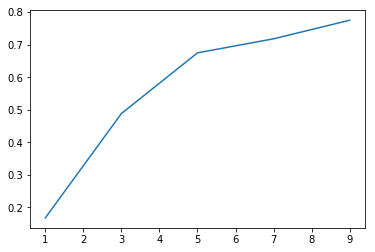

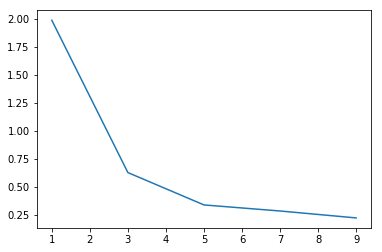

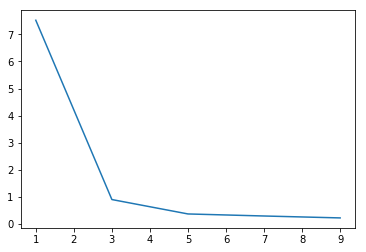

In [24]:
plt.plot(range(1,10,2),acc)
plt.show()
plt.plot(range(1,10,2),mean_abs_err)
plt.show()
plt.plot(range(1,10,2),mean_sqr_err)
plt.show()

#### EXTRA ------------------------------------------

In [166]:
import numpy as np
from sklearn.model_selection import train_test_split
X, y = range(100), range(100)

In [175]:
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.4, random_state=0)

In [176]:
sss.get_n_splits(X, y)

2

In [181]:
for train_index, test_index in sss.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [159]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42, shuffle=True)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

In [144]:
X_train

array([[0, 1],
       [2, 3],
       [4, 5]])

In [ ]:
### RANDOM FOREST REGRESSOR
rfr = RandomForestRegressor(n_estimators=1000, random_state=42)
X = df_base[['311', 'hour_sin', 'hour_cos', 'weekday_sin', 'weekday_cos']]
y = df_base['dbas']
y_pred, y_test = runEstimator(X, y, rfr)
# plotClassifier(y_pred, y_test)
print('Error: ', metrics.mean_absolute_error(y_test, y_pred))

In [ ]:
### CORRELATIONS
plt.matshow(df_base.corr())
### CORRELATION
df_base.corr()
### COVARIANCE
df_base.cov()